## Song Recommender Prototype
The dataset contains
- 1,019,318 unique users
- 384,546 unique MSD songs
- 48,373,586 user-song-playcount triplets

Issues: Too much data. 1) Noise introduced by low-playcount records 2) Taking too long to train models

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv
import seaborn as sns
from tqdm import tqdm

import cornac
from cornac.data import Reader
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.models import Recommender, BPR, WMF

%load_ext autoreload
%autoreload 2
%matplotlib inline
# %tensorflow_version 1.x
import tensorflow as tf

print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

# data processing
MIN_PLAYCOUNT = 2
MAX_PLAYCOUNT = 150
MIN_SONG_PER_USER = 20
MIN_USER_PER_SONG = 50

SEED = 2020
VERBOSE = True

Cornac version: 1.7.1
Tensorflow version: 2.3.0


In [69]:
# triplets = pd.read_csv('raw data/raw_triplets.txt', sep="\t", names=['user_id', 'song_id', 'play_count'])
# songs = pd.read_csv('raw data/songs.csv')
# genre_df = pd.read_csv('raw data/track_genre.txt', header=None, sep='\t', names=['track_id', 'genre'])
# spotify = pd.read_csv('raw data/spotify.csv')
artist_term = pd.read_csv('raw data/artist_term.csv') #already have 99% match rate
lyrics = pd.read_csv('raw data/lyrics.csv')

In [70]:
n_users = triplets.user_id.nunique()
n_songs = triplets.song_id.nunique()
n_ratings = len(triplets)
rating_matrix_size = n_users * n_songs
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of songs: {n_songs}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")
print('user/song ratio:', round(n_users/n_songs, 2))

Number of users: 1019318
Number of songs: 384546
Number of available ratings: 48373586
Number of all possible ratings: 391974659628
----------------------------------------
SPARSITY: 99.99%
user/song ratio: 2.65


In [90]:
len(genre_df)

273936

### 1. filter triplets with limitation on play_count (1,150)

In [122]:
triplets.describe()

,play_count
count,4.837359e+07
mean,2.866859e+00
std,6.437725e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,9.667000e+03


In [71]:
temp = triplets.sort_values('play_count', ascending=False)

In [81]:
len(temp[temp['play_count']>150])/len(temp)

0.0001370996146533358

In [82]:
df = triplets[(triplets['play_count'] <= 150) & (triplets['play_count'] >= 2)]
df.describe()

,play_count
count,1.961099e+07
mean,5.521758e+00
std,7.455061e+00
min,2.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,6.000000e+00
max,1.500000e+02


In [14]:
len(triplets[(triplets['play_count'] > 150)])/len(triplets)

0.0001370996146533358

In [83]:
len(df)

19610988

### 2. Inner-merge triplets to additional datasets
Only use the triplets have additional dataset, so we can recommend songs with aditional information

In [84]:
df = pd.merge(df, songs[['song_id', 'track_id']], on='song_id', how='inner')# songs
df = pd.merge(df, genre_df[['track_id']], on='track_id', how='inner')# genre
df = pd.merge(df, spotify[['song_id']], on='song_id', how='inner')# spotify

lyrics_track = lyrics[['track_id']].drop_duplicates()
df = pd.merge(df, lyrics_track, on='track_id', how='inner')# lyrics

artist = artist_term[['artist_id']].drop_duplicates()
df = pd.merge(df, songs[['song_id', 'artist_id']], on='song_id', how='inner')
df = pd.merge(df, artist, on='artist_id', how='inner')# artist_term

print(df.shape)

(4301953, 5)


In [15]:
4301953/len(triplets)

0.08893186045789535

### 3. filter triplets with limitations on users and songs

In [74]:
triplets_new = df[['user_id', 'song_id', 'play_count']].drop_duplicates()

In [85]:
# limitation on songs: min count of users per song = 50
user_per_song = pd.DataFrame(triplets_new['user_id'].groupby(triplets_new['song_id']).count()).reset_index()
user_per_song.columns = ['song_id', 'user_per_song']
print('Count of unique songs:', len(user_per_song['song_id']))
user_per_song.describe()

Count of unique songs: 34966


,user_per_song
count,34966.000000
mean,123.032460
std,557.974349
min,1.000000
25%,11.000000
50%,29.000000
75%,88.000000
max,44861.000000


In [89]:
song_per_user = pd.DataFrame(triplets_new['song_id'].groupby(triplets_new['user_id']).count()).reset_index()
song_per_user.columns = ['user_id', 'song_per_user']
print('Count of unique users:', len(song_per_user['user_id']))
song_per_user.describe()

Count of unique users: 766792


,song_per_user
count,766792.000000
mean,5.610326
std,7.563517
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,236.000000


In [76]:
user_per_song_filtered = user_per_song[user_per_song['user_per_song']>=50]
print('Count of unique songs after filtering:', len(user_per_song_filtered['song_id']))

Count of unique songs after filtering: 12936


In [77]:
# filtering triplets_new
triplets_filtered = pd.merge(triplets_new, user_per_song_filtered[['song_id']], on='song_id', how='inner')

In [88]:
# limitation on songs: min count of songs per user = 20
song_per_user = pd.DataFrame(triplets_filtered['song_id'].groupby(triplets_filtered['user_id']).count()).reset_index()
song_per_user.columns = ['user_id', 'song_per_user']
print('Count of unique users:', len(song_per_user['user_id']))
song_per_user.describe()

Count of unique users: 29937


,song_per_user
count,29937.000000
mean,30.370244
std,12.912786
min,20.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,198.000000


In [79]:
song_per_user_filtered = song_per_user[song_per_user['song_per_user']>=20]
print('Count of unique users:', len(song_per_user_filtered['user_id']))

song_per_user_filtered.describe()

Count of unique users: 29937


,song_per_user
count,29937.000000
mean,30.370244
std,12.912786
min,20.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,198.000000


In [80]:
# filtering again
triplets_filtered = pd.merge(triplets_filtered, song_per_user_filtered[['user_id']], on='user_id', how='inner')

In [311]:
n_users = triplets_filtered.user_id.nunique()
n_songs = triplets_filtered.song_id.nunique()
n_ratings = len(triplets_filtered)
rating_matrix_size = n_users * n_songs
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of songs: {n_songs}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")
print('user/song ratio:', round(n_users/n_songs, 2))

Number of users: 29937
Number of songs: 12934
Number of available ratings: 909194
Number of all possible ratings: 387205158
----------------------------------------
SPARSITY: 99.77%
user/song ratio: 2.31


In [19]:
len(triplets_filtered)/len(triplets)

0.018795257395223915

In [21]:
len(triplets_filtered)

909194

In [313]:
triplets_filtered.to_csv('filtered data/triplets_final.csv', index=None)

### 4. link filtered triplets to additional datasets

In [314]:
# each song only has one genre
len(genre_df[['track_id']].drop_duplicates())/len(genre_df)

1.0

In [315]:
metadata = pd.merge(triplets_filtered, songs, on='song_id', how='inner')# songs
metadata = pd.merge(metadata, genre_df, on='track_id', how='inner')# genre
print(metadata.shape)

(909194, 17)


In [316]:
song_spotify = pd.merge(triplets_filtered[['song_id']], spotify, on='song_id', how='inner')# spotify
song_spotify

,song_id,spotify_danceability,spotify_energy,spotify_key,spotify_loudness,spotify_mode,spotify_speechiness,spotify_acousticness,spotify_instrumentalness,spotify_liveness,spotify_valence,spotify_tempo,spotify_time_signature
0,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
1,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
2,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
3,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
4,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
5,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
6,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
7,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
8,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0
9,SONKSNV12A58A7F654,0.486,0.268,8.0,-13.025,1.0,0.0266,0.102000,0.000031,0.1160,0.2960,84.065,4.0


In [6]:
temp = pd.merge(triplets_filtered, songs[['song_id', 'track_id', 'title']], on='song_id', how='inner')
song_lyrics = pd.merge(temp, lyrics, on='track_id', how='inner')# lyrics
song_lyrics = song_lyrics.drop('track_id', axis=1)
song_lyrics

,user_id,song_id,play_count,title,mxm_tid,word,count,is_test
0,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,i,5,0
1,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,the,5,0
2,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,you,10,0
3,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,to,4,0
4,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,and,3,0
5,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,a,4,0
6,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,me,4,0
7,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,it,3,0
8,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,not,3,0
9,ea636ccf410a58ba119c2778975a6efc9ebc3da4,SONKSNV12A58A7F654,5,Speed Of Sound,1813134,in,1,0


In [42]:
artist_term

,artist_id,term
0,ARRH63Y1187FB47783,alternative rap
1,ARRH63Y1187FB47783,beats
2,ARRH63Y1187FB47783,black
3,ARRH63Y1187FB47783,classic
4,ARRH63Y1187FB47783,club
5,ARRH63Y1187FB47783,east coast rap
6,ARRH63Y1187FB47783,electro
7,ARRH63Y1187FB47783,fresh
8,ARRH63Y1187FB47783,gangsta
9,ARRH63Y1187FB47783,hip hop


In [49]:
temp = pd.merge(triplets_filtered[['song_id']].drop_duplicates(), songs[['song_id', 'artist_id', 'artist_name']], on='song_id', how='inner')
song_artist_term = pd.merge(temp[['artist_id', 'artist_name']].drop_duplicates(), artist_term, on='artist_id', how='inner')# artist_term

In [52]:
metadata.to_csv('filtered data/metadata.csv', index=None)
song_spotify.to_csv('filtered data/song_spotify.csv', index=None)
song_lyrics.to_csv('filtered data/song_lyrics.csv', index=None)
song_artist_term.to_csv('filtered data/song_artist_term.csv', index=None)

### 5. Stratified split triplets_filtered into trainning and testing

In [18]:
triplets_filtered = pd.read_csv('filtered data/triplets_final.csv')

In [328]:
triplets_filtered.describe()

,play_count
count,909194.000000
mean,4.887874
std,5.733627
min,2.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,150.000000


In [329]:
# limitation on songs: min count of songs per user = 20
song_per_user = pd.DataFrame(triplets_filtered['song_id'].groupby(triplets_filtered['user_id']).count()).reset_index()
song_per_user.columns = ['user_id', 'song_per_user']
print('Count of unique users:', len(song_per_user['user_id']))
song_per_user.describe()

Count of unique users: 29937


,song_per_user
count,29937.000000
mean,30.370244
std,12.912786
min,20.000000
25%,22.000000
50%,26.000000
75%,34.000000
max,198.000000


In [331]:
from sklearn.model_selection import train_test_split
X = triplets_filtered[['user_id', 'song_id']].values
Y = triplets_filtered[['play_count']].values
U = triplets_filtered[['user_id']].values

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=U, random_state=2020)

In [332]:
triplets_train = pd.concat([pd.DataFrame(x_train), pd.DataFrame(y_train)], axis=1)
triplets_test = pd.concat([pd.DataFrame(x_test), pd.DataFrame(y_test)], axis=1)

triplets_train.columns = ['user_id', 'song_id', 'play_count']
triplets_test.columns = ['user_id', 'song_id', 'play_count']
print(triplets_train.shape, triplets_test.shape)

(727355, 3) (181839, 3)


In [16]:
triplets_train.to_csv('filtered data/triplets_final_train.csv', index=None)
triplets_test.to_csv('filtered data/triplets_final_test.csv', index=None)

### 6. EDA

In [2]:
metadata = pd.read_csv('filtered data/metadata.csv')

#### Top 10 songs by number of users who have played it

In [3]:
song_play_num_users = metadata.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users = pd.DataFrame(song_play_num_users).reset_index()
song_play_num_users.columns = ['song_id', 'song_play_num_users']
song_play_num_users = pd.merge(song_play_num_users, metadata[['song_id', 'title']].drop_duplicates(), on='song_id', how='left')
song_play_num_users.head(10)

,song_id,song_play_num_users,title
0,SONYKOW12AB01849C9,3892,Secrets
1,SOPUCYA12A8C13A694,3436,Canada
2,SOCVTLJ12A6310F0FD,3393,Clocks
3,SOKLRPJ12A8C13C3FE,3308,The Scientist
4,SOVDLZN12AB0185BEA,3018,Tighten Up
5,SOLRGVL12A8C143BC3,2669,Bulletproof
6,SOXWYZP12AF72A42A6,2567,Cosmic Love
7,SOUFPNI12A8C142D19,2486,Heartbreak Warfare
8,SOXQYSC12A6310E908,2188,Bitter Sweet Symphony
9,SOSCIZP12AB0181D2F,2159,Alejandro


In [4]:
song_df = metadata[['song_id','artist_name', 'artist_hotttnesss', 'genre', 'year']].drop_duplicates()
sum_play_count = metadata[['song_id', 'play_count']].groupby('song_id').sum().reset_index()
# sum_play_count.comlumns = ['song_id', 'sum_play_count']
song_df = pd.merge(song_df, sum_play_count, on='song_id', how='inner')

In [5]:
song_df = pd.merge(song_play_num_users, song_df, on='song_id', how='left')

In [6]:
song_df

,song_id,song_play_num_users,title,artist_name,artist_hotttnesss,genre,year,play_count
0,SONYKOW12AB01849C9,3892,Secrets,OneRepublic,0.792048,Rock_Contemporary,2009,26008
1,SOPUCYA12A8C13A694,3436,Canada,Five Iron Frenzy,0.487984,Rock_Neo_Psychedelia,0,37465
2,SOCVTLJ12A6310F0FD,3393,Clocks,Coldplay,0.916053,Rock_College,2002,16109
3,SOKLRPJ12A8C13C3FE,3308,The Scientist,Coldplay,0.916053,Pop_Contemporary,2002,16120
4,SOVDLZN12AB0185BEA,3018,Tighten Up,The Black Keys,0.741724,Rock_Alternative,2010,16626
5,SOLRGVL12A8C143BC3,2669,Bulletproof,La Roux,0.557202,Pop_Contemporary,2009,13157
6,SOXWYZP12AF72A42A6,2567,Cosmic Love,Florence + The Machine,0.759102,Rock_College,2009,14295
7,SOUFPNI12A8C142D19,2486,Heartbreak Warfare,John Mayer,0.740374,Rock_Contemporary,0,12132
8,SOXQYSC12A6310E908,2188,Bitter Sweet Symphony,The Verve,0.587810,Pop_Contemporary,1997,10576
9,SOSCIZP12AB0181D2F,2159,Alejandro,Lady GaGa,0.838448,Pop_Contemporary,2009,10463


In [25]:
song_df.groupby('genre').count().song_id/12934

genre
Big_Band                0.003634
Blues_Contemporary      0.005257
Country_Traditional     0.038194
Dance                   0.021958
Electronica             0.036261
Experimental            0.025514
Folk_International      0.013221
Gospel                  0.014226
Grunge_Emo              0.049791
Hip_Hop_Rap             0.060074
Jazz_Classic            0.004871
Metal_Alternative       0.115741
Metal_Death             0.034869
Metal_Heavy             0.039044
Pop_Contemporary        0.059920
Pop_Indie               0.099351
Pop_Latin               0.031854
Punk                    0.034251
Reggae                  0.008659
RnB_Soul                0.016546
Rock_Alternative        0.050951
Rock_College            0.086362
Rock_Contemporary       0.075460
Rock_Hard               0.037885
Rock_Neo_Psychedelia    0.036106
Name: song_id, dtype: float64

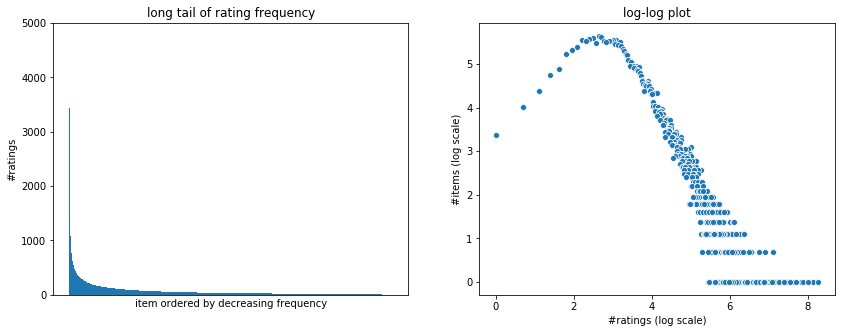

In [36]:
sample_df = song_play_num_users.song_play_num_users
sample_df = sample_df.sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")
axes[0].set_ylim([0, 5000])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");